In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import multiprocessing
import numpy as np
import os
import pandas as pd 
from pathlib import Path
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import torch
import torchaudio as ta 
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import warnings
# Custom project libraries.
import plot_functions as plotting
import utils
import configs

#### Filename structure:

6229: Soundtrap#6229

22: 2022

08: August

21: Hour of day(?)

x: Iterator(?)

In [2]:
# Use NVIDIA GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ignore userwarnings due to TorchAudio deprecating in next major release (2.9.0, late 2025).
# warnings.filterwarnings("ignore", category=UserWarning)

# Path setup.
root_folder = Path().resolve().parents[0]
data_path = Path("D:/data_dryad")
graph_path = root_folder / "bsc_project" / "graphs"

# sample_name = "6229.220802160000.wav"
sample_wav = data_path / "Aug_6229" / "6229.220802160000.wav"

Using device: cuda


In [3]:
metadata = ta.info(sample_wav)
print(metadata)

AudioMetaData(sample_rate=64000, num_frames=17279744, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [4]:
waveform, sample_rate = ta.load(sample_wav)

#### Audio data:
- 64 kHz: higher resolution than common sound (16 kHz).
- 1 channel with 17 million frames.
- time = num_frames / sample_rate $\approx$ 4.5 mins.

#### Basic waveform plot
Runs very slowly because of the high resolution.

Based on https://docs.pytorch.org/audio/stable/tutorials/audio_io_tutorial.html

In [5]:
# plot_waveform(waveform, sample_rate)

#### Faster waveform plot
Only designed for for mono-channel audio.

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Waveform'}, xlabel='Time (seconds)', ylabel='Amplitude'>)

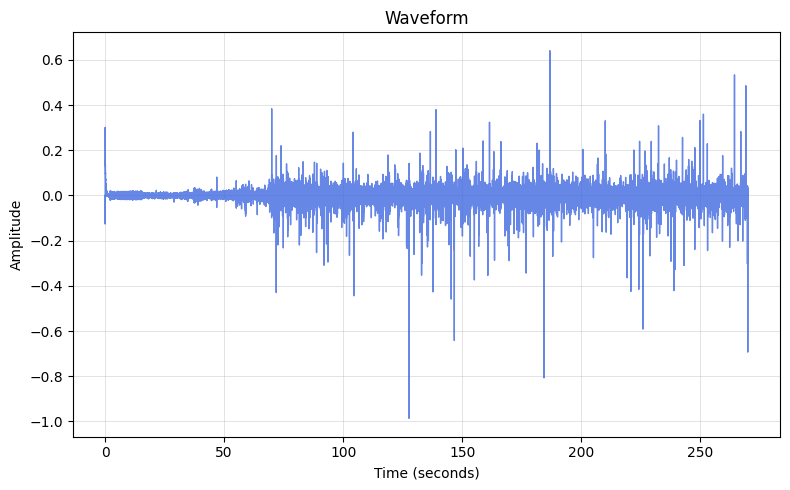

In [6]:
plotting.plot_waveform_fast(waveform, sample_rate)

#### Data loader
- Based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html.
- Set indices for a data subset when developing.

In [7]:
skip_secs = 5
batch_size = 2
dataset = utils.AudioDataset(data_path, target_sr=sample_rate, skip_secs=skip_secs, mode="crop", max_secs=None)
start_idx = 0 # Create a data subset to skip to later recordings.
end_idx = 10 #len(dataset)
subset = Subset(dataset, range(start_idx, end_idx))
loader = DataLoader(subset, batch_size=batch_size, shuffle=False, collate_fn=utils.max_len_collate) # Only shuffle data when training.

In [ ]:
specgram_config = configs.get_specgram_config()
specgram_config

- n_fft: Size of the DFT per frame, creates n_fft // 2 + 1 bins. Larger n_fft yields higher frequency resolution.
- win_length: Number of windowed time samples per frame before FFT. n_fft = win_length means no zero-padding plus the FFT sees only the window. 
- hop_length: hop_length / win_length = overlap ratio. We use 50% overlap. More overlap gives smoother spectrograms.
- window_fn: The Hann window function suppresses spectral leakage (for example, peaks from previous frames leaking into the current position of the sliding window) by tapering the beginning and end of each frame to zero while keeping samples at the center. Combines with overlap to get clear signals.
- Power: The natural input to a log/dB conversion. 

Documentation: https://docs.pytorch.org/audio/stable/generated/torchaudio.transforms.Spectrogram.html

Manually checked data subset up to index $=9 \cdot 40$.

In [9]:
# max_points = 30_000
# rows, cols = 3, 3
# fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
# axes = axes.flatten()
# n_plots = rows * cols 

# file_list = []
# i = 0
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         if i >= n_plots:
#             break
#         p = Path(path).name
#         L = int(l) if hasattr(l, "item") else int(l)
#         waveclip = w[:, :L].detach().cpu()
#         plot_waveform_fast(waveclip, sr, max_points, title=p, ax=axes[i])
#         file_list.append(p)
#         i += 1
#     if i >= n_plots:
#         break 

# plt.tight_layout()
# plt.show()

### Notes
- Every .wav file seems to begin with 1 second of noise.

#### Notable files
'6229.220802160000.wav', '6229.220802162000.wav', '6229.220802164000.wav', '6229.220804080000.wav', '6229.220805090000.wav', '6229.220805094000.wav', '6229.220805100000.wav', '6229.220805102000.wav', '6229.220805104000.wav', '6229.220805110000.wav', '6229.220805112000.wav', '6229.220805114000.wav', '6229.220806052000.wav', '6229.220806184000.wav'

#### Find interesting waveforms with high amplitudes
- Skip the first corrupted seconds. 
- Find waveforms with peaks and fractions of their wave length above amplitude peak $0.3$ and length fraction $5e-6$ (a fraction of a million).

In [10]:
# skip_secs = 2 # skip_secs NOW LIVES IN THE AudioDataset CLASS.
# ampl_threshold = 0.3
# ampl_frac = 5e-6

In [11]:
# max_points = 30_000
# rows, cols = 3, 2
# num_plots = rows*cols
# fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
# axes = axes.flatten()

# wavelist = []
# n_plts = 0
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         if n_plts >= num_plots:
#             break 

#         n_chans, n_frames = w.shape 
#         s_idx = int(sr * skip_secs)
#         waveclip = w[:, :l]
#         waveclip[:, :s_idx] = 0 # Mute the first corrupted seconds of every recording.
#         wavepeak = float(waveclip.abs().max().item())
#         wavefrac = float((waveclip.abs() >= ampl_threshold).float().mean().item())
#         if wavefrac >= ampl_frac and wavepeak >= ampl_threshold:
#             p = Path(path).name
#             wavelist.append((path))
#             plot_waveform_fast(waveclip, sr, max_points, title=p, ax=axes[n_plts])
#             n_plts += 1 

#     if n_plts >= num_plots:
#         break 
# plt.savefig(fname=graph_path / "waveforms_graph.png", dpi=300)
# plt.tight_layout()
# plt.show()

#### Spectrograms
- x-axis: time (seconds).
- y-axis: magnitude of the frequency spectrum calculated using Fourier transform. 
- Frequency: the number of occurring mechanical waves of pressure (the definition of sound) per unit of time. 

In [12]:
sample_name = data_path / "Aug_6229" / "6229.220806184000.wav"
# sample_name = data_path / "Aug_6229" / "6229.220802162000.wav"
# sample_name = data_path / "Aug_6229" / "6229.220802160000.wav"
waveform, sample_rate = ta.load(sample_name)
# Has no spectrogram settings.
# plotting.plot_specgram(waveform, sample_rate, specgram_config, title=r"Spectrogram: " + str(sample_name))
# plt.show()

In [13]:
# utils.plot_nm_specgrams(3, 3, wavelist, data_path=data_path, graph_path=graph_path)

#### Compute stats
Iterate through entire dataset instead of plotting first waveforms encountered above the thresholds.

#### Iterator that runs compute_stats()

In [14]:
# stats_rows = []
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         stats = utils.compute_stats(w, sr, l, skip_secs)
#         stats_rows.append({
#                "filename": Path(path).name,
#                **stats
#         })

# # Save to permanent CSV file.
# fname = "august_stats.csv"
# stats_folder = Path().resolve() / "data_management"
# with open(stats_folder / fname, "w", newline='') as f:
#     cols = ["filename", "duration_sec", "peak_abs", "mean_abs", "rms", "zcr_hz"]
#     writer = csv.DictWriter(f, fieldnames=cols)
#     writer.writeheader()
#     writer.writerows(stats_rows)

# stats_df = pd.read_csv(stats_folder / fname)
# stats_df = stats_df.sort_values(by=["mean_abs", "peak_abs"], ascending=False).reset_index(drop=True)
# stats_df.to_csv(path_or_buf=stats_folder / fname, index=False)

#### Plot highest mean waveforms

In [15]:
# stats_path = root_folder / "bsc_project" / "data_management" / "august_stats.csv"
# df_stats = pd.read_csv(stats_path)
# plot_nm_specgrams(2, 2, df_stats['filename'].tolist()[0:4], fname="Highest mean spectrograms", fig_size=(8, 7))

In [16]:
# plot_nm_waveforms(2, 2, df_stats['filename'].tolist()[0:4], fname="Highest mean waveforms", fig_size=(8, 7))

In [17]:
# specgram_config["n_mels"] = 128
# specgram_config["n_fft"] = 1024
specgram_config

{'sample_rate': 64000,
 'n_fft': 512,
 'win_length': 512,
 'hop_length': 256,
 'window_fn': <function torch._VariableFunctionsClass.hann_window>,
 'resample_rate': None,
 'n_mels': 256,
 'power': 2.0,
 'center': True,
 'pad_mode': 'reflect',
 'f_min': 0.0,
 'f_max': 32000.0}

### Logmel transformation
- Reference implementation: https://docs.pytorch.org/audio/stable/transforms.html
- Reference also has an augmentation technique to increase robustness.

In [18]:
logmel_transf = utils.PipelineSpecgram(specgram_config=specgram_config)
logmel_transf.to(device=device, dtype=torch.float32)
waveform = waveform.to(device=device, dtype=torch.float32)
feats = logmel_transf(waveform) # The pipeline returns acoustic features.

c:\Users\Lindholm\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


#### Notes
If mel scale is enabled:
- The raw data inputs are given in relative Pascals (rel Pa).
- Transformation pipeline returns the shape [C, M, T] for C channels in the input waveform (always 1 here), M mel bins and T time frames.
- Units are decibels (dB) of log mel-band power. The default of AmplitudeToDB(stype="power") is
$$
10 \cdot \log 10 (\frac{P}{\texttt{ref}})
$$
where ref = 1.0 and it applies logarithmic transformation.
- y-axis unit: Mel bin is the index of a mel band. Each row is one Mel filter's output.
- OR compute kHz labels.
- Colorbar represents amplitude scale: with power = 2.0 and AmplitudeToDB and $p_{ref}=1 \mu Pa$, then the amplitude scale is dB re 1 $\mu Pa$ per mel band.


In [19]:
# for batch in loader:
#     waves = batch["waveform"].to(device=device, dtype=torch.float32) # [B, C, T]
#     feats = logmel_transf(waves)
#     paths = batch["paths"]
#     B = feats.shape[0]
#     for i in range(B):
#         f = feats[i]
#         plotting.plot_features(f, logmel_transf, specgram_config)
#         print(paths[i])
#         plt.show()

In [20]:
# w1, sr1 = ta.load(paths[0])
# f1 = logmel_transf(w1.to(device=device, dtype=torch.float32))

# fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, constrained_layout=True)
# axes = axes.flatten()
# plotting.plot_waveform_fast(w1, sr1, ax=axes[0])
# plotting.plot_features(f1, logmel_transf, specgram_config, ax=axes[1])
# plt.tight_layout()
# plt.show()

#### To do: Implement easy plotting of time windows

In [21]:
# w1, sr1 = ta.load(paths[0])
# f1 = logmel_transf(w1.to(device=device, dtype=torch.float32))

# fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, constrained_layout=True)
# axes = axes.flatten()
# time = (sr1*120, sr1*120*5)
# plotting.plot_waveform_fast(w1[:, time[0]:time[1]], sr1, ax=axes[0])
# plotting.plot_features(f1[:, :, time[0]:time[1]], logmel_transf, specgram_config, ax=axes[1])
# plt.tight_layout()
# plt.show()

#### Build X (reduction with strides) as input to clustering algorithms

In [22]:
logmel_transf = utils.PipelineSpecgram(specgram_config=specgram_config)
logmel_transf = logmel_transf.to(device)

max_points = 1_000
X, ids = utils.tensors_to_array(dataloader=loader, transform=logmel_transf, max_pts=max_points, device=device, dtype=np.float32)

In [23]:
X.shape

(10, 512)

## Clustering algorithms

In [24]:
graph_path = Path.cwd() / "graphs" / "week6-7_figs"

#### k-means++

In [25]:
seed = 104 # Constant random seed for clustering initialization.
k = 8 # k clusters. 
b = 256 * multiprocessing.cpu_count() # Batch size for 12 logical cores.
kmeans = MiniBatchKMeans(
    n_clusters=k,
    init="k-means++",
    n_init=10,
    batch_size=b,
    max_iter=100,
    random_state=seed
)

#### k-means clustering with L1 normalization

In [26]:
X_l1 = normalize(X, norm="l1", axis=1) # Row-wise L1 normalization.
kmeans.fit(X_l1)
l1_labels = kmeans.labels_
l1_centers = kmeans.cluster_centers_ 
l1_inertia = kmeans.inertia_
l1_silhs = silhouette_score(X_l1, l1_labels)

print(f"Inertia: {l1_inertia:.3f}")
print(f"Silhouette Score: {l1_silhs:.3f}")

Inertia: 0.000
Silhouette Score: -0.013


In [27]:
pca_reducer = PCA(n_components=2, random_state=seed)
Z = pca_reducer.fit_transform(X_l1)
Z_centers = pca_reducer.transform(l1_centers)

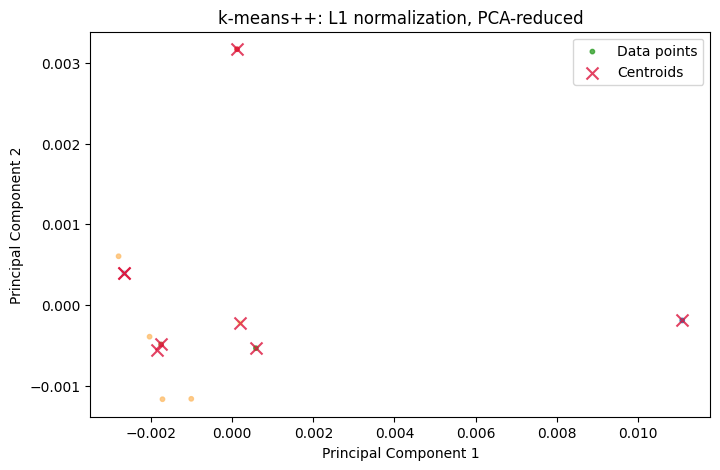

In [28]:
cmap = mpl.colormaps.get_cmap("Paired")

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(Z[:, 0], Z[:, 1], c=l1_labels, cmap=cmap, s=10, alpha=0.8, label="Data points")
ax.scatter(Z_centers[:, 0], Z_centers[:, 1], c="crimson", alpha=0.8, s=75, marker="x", label="Centroids")

# ax.set_xlim(-0.001, 0.001)
# ax.set_ylim(-0.001, 0.001)
ax.set_title("k-means++: L1 normalization, PCA-reduced")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")

plt.savefig(fname=graph_path / f"kmeans_L1_pca_{max_points}.png", dpi=300)

ax.legend()
plt.show()

In [29]:
# print(ids[Z.argmin(axis=0)[0]]) # Loud crashing noise
# print(ids[Z.argmax(axis=0)[0]]) # Loud crashing noise.

##### L1 normalization
- Scales each row to so they sum to 1.
- Notice the tiny scale between -0.01 and 0.01.
- Negative silhouette score means points are often closer to the wrong cluster center than their assigned cluster label.

#### k-means with L2 normalization
- Approximates Euclidean distance on the unit sphere.

In [30]:
# X_l2 = normalize(X, norm="l2", axis=1)
# batch_kmeans.fit(X_l2)
# l2_labels = batch_kmeans.labels_
# l2_centers = batch_kmeans.cluster_centers_
# l2_inertia = batch_kmeans.inertia_
# l2_silhs = silhouette_score(X_l2, l2_labels)

In [31]:
# print(f"Inertia: {l2_inertia:.3f}")
# print(f"Silhouette Score: {l2_silhs:.3f}")

In [32]:
# Z_l2 = pca_reducer.fit_transform(X_l2)
# Z_centers_l2 = pca_reducer.transform(l2_centers)

In [33]:
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.scatter(Z_l2[:, 0], Z_l2[:, 1], cmap=cmap, c=l2_labels, s=10, alpha=1, label="Data points")
# ax.scatter(Z_centers_l2[:, 0], Z_centers_l2[:, 1], c="black", alpha=0.8, s=75, marker="x", label="Centroids")

# ax.set_title("k-means++: L2 normalization, PCA-reduced")
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")

# plt.savefig(fname=graph_path / f"kmeans_L2_pca_{max_pts/1000}.png", dpi=300)

# ax.legend()
# plt.show()

##### L2 normalization
- Scales each waveform's Euclidean length to sum to 1.
- Waveforms are projected onto the unit hypersphere.
- Similar waveform shapes are clustered together even though their amplitude is different (amplitude differences could be due to loudness).
- Scale is still small and silhouette score is $\approx 0$.

#### t-SNE: no preprocessing

In [34]:
# tsne = TSNE(n_components=2, init="pca", perplexity=30, random_state=seed, learning_rate="auto")
# Z_tsne = tsne.fit_transform(X)

In [35]:
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.scatter(Z_tsne[:, 0], Z_tsne[:, 1], cmap=cmap, c=l2_labels, s=10, alpha=1, label="Data points")

# ax.set_title("t-SNE dimensional reduction")

# plt.savefig(fname=graph_path / f"tsne_{max_pts}.png", dpi=300)

# ax.legend()
# plt.show()

##### t-SNE
- Computes pairwise similarities as probabilities in both high and low dimensional spaces, then minimizes the difference between the high and low dimensional probability distributions. 
- Perplexity: measures how many neighbors to consider.

#### t-SNE with preprocessing: L2 normalization, standardization (0 mean, 1 variance), PCA-reduction

In [36]:
# X_std = StandardScaler(with_mean=True, with_std=True).fit_transform(X_l2)
# tsne_pca = PCA(n_components=50, random_state=seed, svd_solver="auto")
# X_tsne_pca = tsne_pca.fit_transform(X_std)
# tsne = TSNE(n_components=2, init="pca", perplexity=30, random_state=seed, learning_rate="auto", max_iter=2000)
# Z_tsne_pca = tsne.fit_transform(X_tsne_pca)

In [37]:
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.scatter(Z_tsne_pca[:, 0], Z_tsne_pca[:, 1], cmap=cmap, c=kbm_labels, s=10, alpha=1, label="Data points")

# ax.set_title("t-SNE reduction (preprocessing: L2, standardization, PCA) dimensional reduction")

# plt.savefig(fname=graph_path / f"tsne_pca_standard_{int(max_pts/1000)}k.png", dpi=300)

# ax.legend()
# plt.show()

#### Agglomerative clustering with cosine distance

In [38]:
# AC_model = AgglomerativeClustering(n_clusters=k, metric="cosine", linkage="average")
# labels_ac_cos = AC_model.fit_predict(Z_tsne)
# silhs_ac_cos = silhouette_score(Z_tsne, labels_ac_cos, metric="cosine")

# Z_ac_cos = pca_reducer.fit_transform(Z_tsne)

# print(f"Agglomerative Clustering Silhouette Score: {silhs_ac_cos:.3f}")

In [39]:
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.scatter(Z_ac_cos[:, 0], Z_ac_cos[:, 1], cmap=cmap, c=labels_ac_cos, s=10, alpha=1, label="Data points")

# ax.set_title("Agglomerative clustering based on t-SNE (PCA-reduced)")

# plt.savefig(fname=graph_path / f"ac_cosine_tsne_pca_{max_pts}.png", dpi=300)

# ax.legend()
# plt.show()

In [40]:
# K = len(np.unique(labels_ac_cos))
# clst_idx = {c: np.where(labels_ac_cos == c)[0] for c in range(K)}
# clst_files = {c: [ids[j] for j in clst_idx[c]] for c, idxs in clst_idx.items()}
# rng = np.random.default_rng(seed)
# samples = 1
# clst_samples = {c: rng.choice(idxs, size=min(samples, len(idxs)), replace=False).tolist() for c, idxs in clst_idx.items()}
# clst_sample_files = {c: [ids[i] for i in idxs] for c, idxs in clst_samples.items()}
# clst_sample_files_lbls = [(c, fname) for c, files in clst_sample_files.items() for fname in files]
# plt_samples = [fname for files in clst_sample_files.values() for fname in files]
# print(clst_sample_files_lbls)

#### Agglomerative cluster with L2 normalization.

In [41]:
# AC_model = AgglomerativeClustering(n_clusters=k, metric="cosine", linkage="average")
# labels_ac_l2 = AC_model.fit_predict(X_l2)
# silhs_ac_l2 = silhouette_score(X_l2, labels_ac_l2)

# Z_ac_l2 = pca_reducer.fit_transform(X_l2)

# print(f"Agglomerative Clustering Silhouette Score: {silhs_ac_l2:.3f}")

In [42]:
# fig, ax = plt.subplots(figsize=(8, 5))

# ax.scatter(Z_ac_l2[:, 0], Z_ac_l2[:, 1], cmap=cmap, c=labels_ac_l2, s=10, alpha=1, label="Data points")

# plt.savefig(fname=graph_path / f"ac_l2_tsne_pca_{int(max_pts/1000)}k.png", dpi=300)

# ax.set_title("Agglomerative clustering based on L2 (PCA-reduced)")
# ax.legend()
# plt.show()

In [43]:
# K = len(np.unique(labels_ac_l2))
# clst_idx = {c: np.where(labels_ac_l2 == c)[0] for c in range(K)}
# clst_files = {c: [ids[j] for j in clst_idx[c]] for c, idxs in clst_idx.items()}
# rng = np.random.default_rng(seed)
# samples = 10
# clst_samples = {c: rng.choice(idxs, size=min(samples, len(idxs)), replace=False).tolist() for c, idxs in clst_idx.items()}
# clst_sample_files = {c: [ids[i] for i in idxs] for c, idxs in clst_samples.items()}
# clst_sample_files_lbls = [(c, fname) for c, files in clst_sample_files.items() for fname in files]
# plt_samples = [fname for files in clst_sample_files.values() for fname in files]
# print(clst_sample_files_lbls)

### Listening to recordings

##### Second highest absolute mean: white noise, distant crashing noise.

In [44]:
# s1 = os.path.join(data_path, "6229.220805100000.wav")
# w1, sr1 = T.load(s1)
# fig1, ax1 = plt.subplots(figsize=(7, 5))
# utils.plot_waveform_fast(w1, sr1, max_pts=30000, ax=ax1, title="6229.220805100000.wav")
# plt.savefig(fname=graph_path / "listening_week_5" / "6229.220805100000.png", dpi=300)

##### Min and max dimensional outliers in k-means L1 cluster: Loud crashing noises.

In [45]:
# s2 = os.path.join(data_path, "6229.220830144000.wav")
# w2, sr2 = T.load(s2)
# fig2, ax2 = plt.subplots(figsize=(7, 5))
# utils.plot_waveform_fast(w2, sr2, max_pts=30000, ax=ax2, title="6229.220830144000.wav")
# plt.savefig(fname=graph_path / "listening_week_5" / "6229.220830144000.png", dpi=300)

In [46]:
# s3 = os.path.join(data_path, "6229.220827194000.wav")
# w3, sr3 = T.load(s3)
# fig3, ax3 = plt.subplots(figsize=(7, 5))
# utils.plot_waveform_fast(w3, sr3, max_pts=30000, ax=ax3)

##### Biggest waveform integral area: droning motor sounds from a boat. 
- Is a single cluster label in agglomerative L2 clustering

In [47]:
# s4 = os.path.join(data_path, "6229.220802162000.wav")
# w4, sr4 = T.load(s4)
# fig4, ax4 = plt.subplots(figsize=(7, 5))
# utils.plot_waveform_fast(w4, sr4, max_pts=30000, ax=ax4, title="6229.220802162000.wav")
# plt.savefig(fname=graph_path / "listening_week_5" / "6229.220802162000.png", dpi=300)

##### Boat sounds have gotten closer.

In [48]:
# s5 = os.path.join(data_path, "6229.220802160000.wav")
# w5, sr5 = T.load(s5)
# fig5, ax5 = plt.subplots(figsize=(7, 5))
# utils.plot_waveform_fast(w5, sr5, max_pts=30000, ax=ax5)

##### Agglomerative clustering with cosine distance: different labels
- All four sound like faint/distant splashes in water.

In [49]:
# plot_nm_waveforms(2, 2, plt_samples[0:4], fname="AC cluster sample waveforms", fig_size=(8, 8))
# plt.savefig(fname=graph_path / "listening_week_5" / "AC_cluster_sample_labels.png", dpi=300)

##### Agglomerative clustering (L2): different labels
- White noise, turbulent water?

In [50]:
# s6 = os.path.join(data_path, "6229.220823124000.wav")
# w6, sr6 = T.load(s6)
# fig6, ax6 = plt.subplots(figsize=(7, 5))
# utils.plot_waveform_fast(w6, sr6, max_pts=30000, ax=ax6, title="6229.220823124000.wav")
# plt.savefig(fname=graph_path / "listening_week_5" / "6229.220823124000.png", dpi=300)